# Learn to Rank
https://www.tensorflow.org/ranking/tutorials/quickstart

https://www.geeksforgeeks.org/train-a-model-using-lightgbm/#
https://gist.github.com/darcyabjones/ace0934ae19c56ed4babc50167f282b0#file-ltr_presentation-ipynb
https://hav4ik.github.io/learning-to-rank/

In [268]:
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

In [269]:
# load up full data
complete = pd.read_csv('https://scmcqueen.github.io/StarTrekScriptData/complete_data.csv').reset_index()
complete.columns = ['index','line','character', 'quote', 'scene', 'location', 'view',
       'episode', 'date', 'series', 'file']
complete['quote']=complete['quote'].apply(lambda text: " ".join(text.split()))
complete['character']=complete['character'].fillna('NA')
complete['character']=complete['character'].apply(lambda x: x.replace('"','').replace('\t',''))
complete.head()

,index,line,character,quote,scene,location,view,episode,date,series,file
0,0,0,QUARK,"You know, Morn -- there's nothing quite as inv...",Al INT. QUARK'S,QUARK'S,INT.,STAR TREK: DEEP SPACE NINE,1996-08-29,Deep Space Nine,504.txt
1,1,1,ROM,What's this?,Al INT. QUARK'S,QUARK'S,INT.,STAR TREK: DEEP SPACE NINE,1996-08-29,Deep Space Nine,504.txt
2,2,2,QUARK,"What do you mean, ""what's this?"" It's puree of...",Al INT. QUARK'S,QUARK'S,INT.,STAR TREK: DEEP SPACE NINE,1996-08-29,Deep Space Nine,504.txt
3,3,3,ROM,I didn't order it.,Al INT. QUARK'S,QUARK'S,INT.,STAR TREK: DEEP SPACE NINE,1996-08-29,Deep Space Nine,504.txt
4,4,4,QUARK,"Of course you ""didn't order it"" -- you don't n...",Al INT. QUARK'S,QUARK'S,INT.,STAR TREK: DEEP SPACE NINE,1996-08-29,Deep Space Nine,504.txt


In [270]:
# load up ratings
ratings = pd.read_csv('skyeler_ranking_data.csv',index_col=0)


In [271]:
# now we need to merge them

# drop the quote & unnamed 0
ratings.drop(columns=['Unnamed: 0','quote'],inplace=True)
ratings.columns = ['index','query','ranking']
ratings.ranking = ratings.ranking.apply(lambda z: ratings.ranking.max()+1 if z < 0 else z)
full_data = ratings.merge(complete,on=['index'],how='left')

In [272]:
full_data.head()

,index,query,ranking,line,character,quote,scene,location,view,episode,date,series,file
0,66191,men,17,333,LARELL,Two men.,34 INT. QUARK'S QUARTERS,QUARK'S QUARTERS,INT.,Who Mourns for Morn?,1997-10-28,Deep Space Nine,536.txt
1,120092,men,5,171,RIKER,What about the men?,20A INT. CARGO HOLD,CARGO HOLD,INT.,Up the Long Ladder,1989-03-17,The Next Generation,144.txt
2,46258,men,1,287,EZRI,Because they're men.,38 INT. QUARK'S - ON SARINA,QUARK',INT.,Chrysalis,1998-08-14,Deep Space Nine,555.txt
3,60897,men,17,250,BASHIR,They're your own men.,64 INT. JEM'HADAR CAVERN - DAY,JEM'HADAR CAVER,INT.,Rocks and Shoals,1997-07-24,Deep Space Nine,527.txt
4,1085,men,17,237,HERBERT,And men from Mars are?,33 INT. MAGAZINE OFFICE - DAY,MAGAZINE OFFIC,INT.,Far Beyond the Stars,1997-11-14,Deep Space Nine,538.txt


In [273]:
# feature engineering
full_data['quote_len']=full_data['quote'].apply(lambda z: len(z.split()))

quote_count = complete.groupby('character').count()['quote']

full_data['total_quotes_char']=full_data['character'].apply(lambda x: quote_count[x])


In [274]:
full_data.head()

,index,query,ranking,line,character,quote,scene,location,view,episode,date,series,file,quote_len,total_quotes_char
0,66191,men,17,333,LARELL,Two men.,34 INT. QUARK'S QUARTERS,QUARK'S QUARTERS,INT.,Who Mourns for Morn?,1997-10-28,Deep Space Nine,536.txt,2,40
1,120092,men,5,171,RIKER,What about the men?,20A INT. CARGO HOLD,CARGO HOLD,INT.,Up the Long Ladder,1989-03-17,The Next Generation,144.txt,4,8138
2,46258,men,1,287,EZRI,Because they're men.,38 INT. QUARK'S - ON SARINA,QUARK',INT.,Chrysalis,1998-08-14,Deep Space Nine,555.txt,3,1050
3,60897,men,17,250,BASHIR,They're your own men.,64 INT. JEM'HADAR CAVERN - DAY,JEM'HADAR CAVER,INT.,Rocks and Shoals,1997-07-24,Deep Space Nine,527.txt,4,5474
4,1085,men,17,237,HERBERT,And men from Mars are?,33 INT. MAGAZINE OFFICE - DAY,MAGAZINE OFFIC,INT.,Far Beyond the Stars,1997-11-14,Deep Space Nine,538.txt,5,32


In [275]:
# train test split my data
train, test = train_test_split(full_data,test_size=.15,random_state=56)
# sort my train values
train = train.sort_values('query')
test = test.sort_values('query')

In [276]:
train_y = list(train['ranking']) # made a list instead of series
train_X = train.drop(columns=['query','ranking','quote','date','scene','index'])
groups = train['query'].value_counts().reset_index().sort_values('query')['count'].values

In [277]:
train_X.sample(2)

,line,character,location,view,episode,series,file,quote_len,total_quotes_char
1074,145,COLLINS,VALIAN,INT.,Valiant,Deep Space Nine,546.txt,1,34
622,274,DATHON,PLANE,EXT.,Darmok,The Next Generation,202.txt,5,54


In [278]:
num_attribs = list(train_X.select_dtypes(include=[np.number]))  # bill length, bill depth, body mass
cat_attribs = list(train_X.select_dtypes(exclude=[np.number]))  # species, island, sex

# takes in sequence of tuples
full_pipeline = ColumnTransformer([
        ("num", StandardScaler(), num_attribs),   # scales the numerical attributes down!
        ("cat", OneHotEncoder(handle_unknown='ignore'), cat_attribs),    # turns the categorical term into a vector
    ])

train_prep = full_pipeline.fit_transform(train_X)


In [358]:
num_names = full_pipeline.named_transformers_["num"].get_feature_names_out(num_attribs)
cat_names = full_pipeline.named_transformers_["cat"].get_feature_names_out(cat_attribs)
total_names = list(num_attribs)+list(cat_names)

In [279]:
test_y = list(test['ranking'])
test_X = test.drop(columns=['query','ranking','quote','date','scene','index'])
t_groups = test['query'].value_counts().reset_index().sort_values('query')['count'].values
test_prep = full_pipeline.transform(test_X)

In [343]:
train_data =lgb.Dataset(train_prep, label=train_y, group=groups,params={'min_data_in_leaf':1})
valid_data = lgb.Dataset(test_prep,label=test_y,group=t_groups)

In [293]:
full_pipeline['cat'].get_feature_names_out()

array(['character_ADMINISTRATOR', 'character_AKOREM',
       'character_ALEXANDER', ..., 'file_572.txt', 'file_574.txt',
       'file_575.txt'], dtype=object)

In [349]:
params = {
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'learning_rate': 0.01,
    'num_leaves': 19, # 31
    'task':'train',
    # 'feature_pre_filter':False,
    "num_leaves": 255,
    "feature_pre_filter": False,
#   "min_data_in_leaf": 1,
    'max_depth':40,
    'verbose':-1
    # 'max_depth':-1
}
res = {}

In [350]:
ranker = lgb.train(params, train_data, num_boost_round=250,valid_sets=[valid_data])

In [363]:
type(ranker)

lightgbm.basic.Booster

In [352]:
ranker.best_score

defaultdict(collections.OrderedDict,
            {'valid_0': OrderedDict([('ndcg@1', 0.8105639621177936),
                          ('ndcg@2', 0.857497945999984),
                          ('ndcg@3', 0.9069779981172439),
                          ('ndcg@4', 0.917861173204151),
                          ('ndcg@5', 0.9236669658616208)])})

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

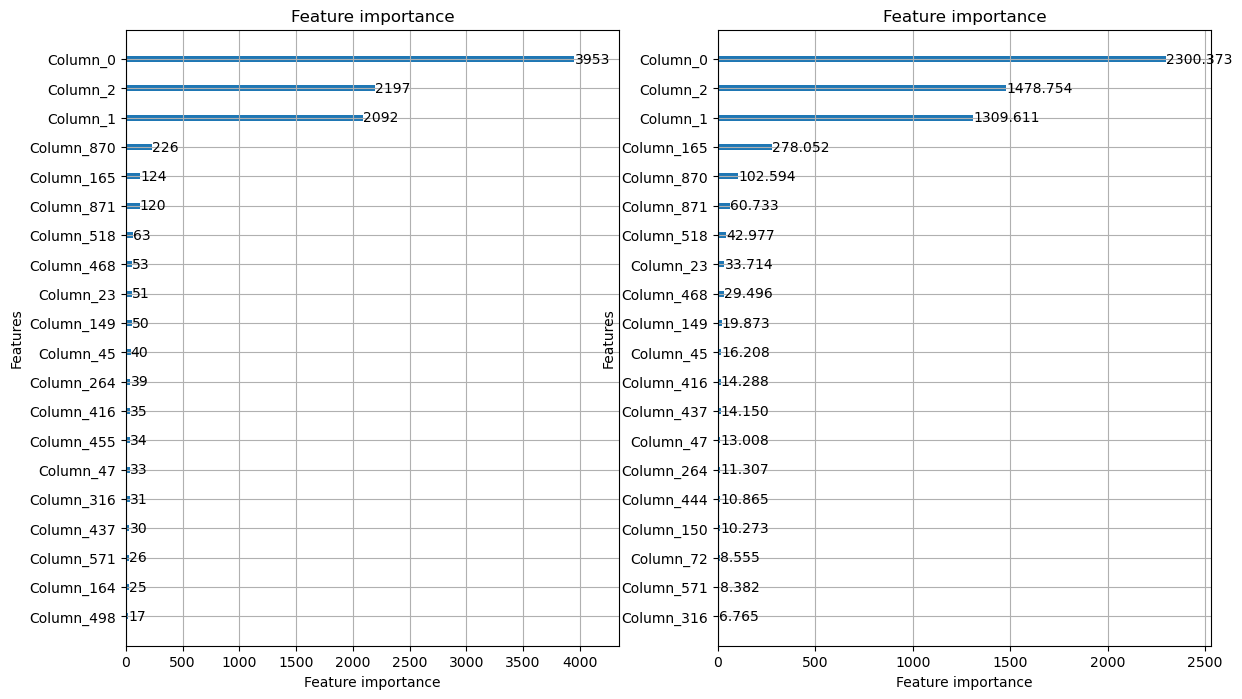

In [351]:
fig, ax = plt.subplots(1, 2, figsize=(14, 8))
lgb.plot_importance(ranker, importance_type='split', ax=ax[0], max_num_features=20)
lgb.plot_importance(ranker, importance_type='gain', ax=ax[1], max_num_features=20)

In [365]:
# Top Features
total_names[0], total_names[2], total_names[1], total_names[870],total_names[165]

('line',
 'total_quotes_char',
 'quote_len',
 'series_Deep Space Nine',
 'character_RIKER')

### I built a ranker model!

My simple, starting model has been built. The most important features were the line number in the episode ('line'), the total quotes a character has across both series, the length of the quote, the series, and whether the speaker is Riker.

Now, I want to functionize this process and add even more features.

# More Learning2Rank

More ideas: Lines per episode, lines per series, sentiment analysis.

In [ ]:
def preprocess_data(complete:pd.DataFrame,ratings:pd.DataFrame)->dict:
    '''Pre-processes the ranking data.

    Returns training data & validation data
    '''
    output = {} # initialize output dict

    # drop unneeded columns
    ratings.drop(columns=['Unnamed: 0','quote'],inplace=True)
    ratings.columns = ['index','query','ranking']

    # replace rankings of 0 to max level (1 is highest ranking)
    ratings.ranking = ratings.ranking.apply(lambda z: ratings.ranking.max()+1 if z < 0 else z)

    # get the full data & join
    full_data = ratings.merge(complete,on=['index'],how='left')

    #----------------- FEATURE ENGINEERING -----------------
    # length of quote
    full_data['quote_len']=full_data['quote'].apply(lambda z: len(z.split()))
    # character overall quotes in df
    quote_count = complete.groupby('character').count()['quote']
    full_data['total_quotes_char']=full_data['character'].apply(lambda x: quote_count[x])

In [370]:
x=complete.groupby(['character','series']).count()['quote']
x['WORF','Deep Space Nine']

2175